In [1]:
%matplotlib inline
%autosave 0

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math

Autosave disabled


# Import data

In [2]:
ex2data = np.genfromtxt("/Users/nunopires/Documents/Coursera/machine-learning-ex2/ex2/ex2data1.txt", delimiter=',')

print ex2data[:5]

[[ 34.62365962  78.02469282   0.        ]
 [ 30.28671077  43.89499752   0.        ]
 [ 35.84740877  72.90219803   0.        ]
 [ 60.18259939  86.3085521    1.        ]
 [ 79.03273605  75.34437644   1.        ]]


In [3]:
# create X and Y matrices, one observation per row
X = ex2data[:,:2]
Y = ex2data[:,2]
Y = Y.reshape(Y.size, 1)

# add column with ones (intercept) to X
X = np.hstack((np.ones((Y.size, 1)), X))

print X.shape, Y.shape

(100, 3) (100, 1)


# Plot data

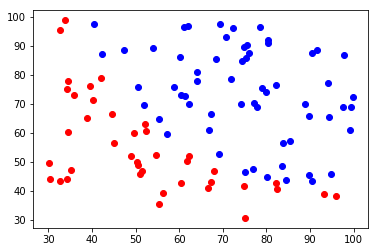

In [4]:
on = Y[:,0] == 1
off = Y[:,0] == 0

plt.plot(X[on, 1], X[on, 2], 'o', color = 'blue'); # Y positives
plt.plot(X[off, 1], X[off, 2], 'o', color = 'red'); # Y negatives

## Calculate sigmoid function

In [5]:
def sigmoid(x):
    '''Compute the sigmoid function '''
    return 1 / (1 + np.exp(-x)) # use numpy.exp, because math.exp only works with scalars

## Calculate cost J

In [6]:
def computeJ(theta, X, Y, lamb):
    '''Compute the cost function.
    input theta should have ndim = 1 to be able to be used in minimise function'''
    
    theta = theta.reshape(X.shape[1],1)
    lamb = float(lamb)

    m = Y.size # number observations
    h = sigmoid(np.dot(X, theta))
    J = np.sum((-Y * np.log(h)) - ((1. - Y) * np.log(1. - h))) / m
    
    reg = (lamb/(2*m)) * np.sum((theta[1:])**2)
    
    return J + reg

# test
# computeJ(theta, Xt, Y, 1)

## Transform features

In [7]:
def transformFeat(x):
    '''transform x1 and x2 variables from a matrix n x 3
    into x1 ,x2, x1^2 and x2^2 from matrix n x 5'''
    
    if X.shape[1] !=3:
        raise ValueError('transformFeat only works with matrices with n x 3')
        
    return np.hstack((x , x[:,1:2]**2, -x[:,2:3]**2))

## Scale features

Scale features: this function should be applied in the same way to future data: the mean and sd values should be calculated only once

In [8]:
def scaling_params(x):
    x = x[:,1:]
    sc_mean = x.mean(axis = 0)
    sc_std = x.std(axis = 0)
    
    return sc_mean, sc_std

def scale(x, mean, std):
    '''scale [,1:] variables from a matrix, except the first (intercept) column'''
    
    x = x[:,1:]
    out = (x - sc_mean) / sc_std
    out = np.hstack((np.ones((x.shape[0], 1)), out))
    
    return out

## Compare J minimization algorithms
Octave's fminunc function was used in Coursera. The alternative in Python is [Scipy's optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) family.

BFGS would be the closest to fminunc (? not clear), but the implementation is not working either with a custom gradient (does not work at all, problem seems to be matrix multiplications and/or very extreme logit values) or without (thetas are way too high).

Best option appears to be the simplest, the Nelder-Mead method(Simplex algorithm), which is anyway a derivative-free method).

* Expected theta values for simple logit regression (no feature transformation) are:
[-25.161, 0.206, 0.201]

## Set initial theta and select scaling

In [9]:
# initialize theta
#init_theta = np.zeros((5))
init_theta = np.array([10, 0, 0, 0, 0])

# use scaling?
scaling = 'off'


In [10]:
# transform X
Xt = transformFeat(X)

if scaling == 'on':
    
    # scale X
    #   --- get scaling params
    sc_mean, sc_std = scaling_params(Xt)
    #   --- apply scaling
    Xt = scale(Xt, sc_mean, sc_std)


for alg in ['Nelder-Mead', 'BFGS', 'Powell', 'CG', 'L-BFGS-B', 'TNC', 'SLSQP']:
    
    temp = minimize(computeJ,
                    x0 = init_theta,
                    args = (Xt, Y, 1),
                    method=alg)
    
    print '---', alg, 'estim = ', temp.x, 'J = ', temp.fun

/Users/nunopires/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/nunopires/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in multiply
/Users/nunopires/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


--- Nelder-Mead estim =  [ -1.30834799e+02   1.78534365e+00   1.30938826e+00  -9.22700198e-03
   5.25990970e-03] J =  0.0652659102195
--- BFGS estim =  [   9.76589581  -12.18044995  -12.78637659 -704.04524542  757.40396118] J =  nan
--- Powell estim =  [ 210.06253249  212.21017485  212.21017485  212.21017485  212.21017485] J =  nan
--- CG estim =  [   9.76589581  -12.18044995  -12.78637659 -704.04524542  757.40396118] J =  nan
--- L-BFGS-B estim =  [ 10.   0.   0.   0.   0.] J =  nan
--- TNC estim =  [  4.85716711e+00  -1.90975860e-01  -1.53507060e-01   2.21907754e-03
  -1.84164314e-03] J =  0.413973368818
--- SLSQP estim =  [ nan  nan  nan  nan  nan] J =  nan


Algorithms are extremely sensitive to the initial theta: when setting it to zeros, predictions are way off. Setting it to an intercept of 10 fixed the problem.

## Get estimates for theta

In [27]:
estim = minimize(computeJ,
                 x0 = init_theta,
                 args = (Xt, Y, 1),
                 method='Nelder-Mead').x
print estim

[ -1.30834799e+02   1.78534365e+00   1.30938826e+00  -9.22700198e-03
   5.25990970e-03]


/Users/nunopires/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/nunopires/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in multiply


### Make predictions
This gives the probability of a positive result

In [28]:
def passing(x1, x2, thetas, scaling):
    
    grade = np.array([1, x1, x2])
    X = transformFeat(grade.reshape(1,3))

    if scaling == 'on':
        X = scale(X, sc_mean, sc_std)

    return sigmoid(np.dot(X, thetas)).item()

passing(5, 75, estim, 'off')

5.699703558152181e-24

# Plot decision boundary


Using *np.meshgrid* would be an easier way to make the grid calculations for the contour plot. However, it was not working properly with the matrix input: so instead made the grid search manually using for loops

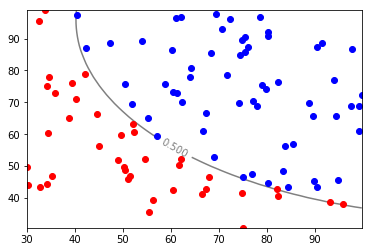

In [29]:
# create search grid
grain = 50
gridX1 = np.linspace(min(X[:,1]), max(X[:,1]), grain)
gridX2 = np.linspace(min(X[:,2]), max(X[:,2]), grain)

# calculate regression for all grid points
z = np.zeros((grain, grain))

for idx1, val1 in enumerate(gridX1):
    for idx2, val2 in enumerate(gridX2):
        z[idx1, idx2] = passing(val1, val2, estim, scaling = 'off')
        
# Plot 
on = Y[:,0] == 1 # positives
off = Y[:,0] == 0 # negatives

h = plt.contour(gridX1, gridX2, z,
                levels = [0.5],
                colors=('grey'))
plt.clabel(h, inline=1, fontsize=10)
plt.plot(X[on, 1], X[on, 2], 'o', color = 'blue'); # Y positives
plt.plot(X[off, 1], X[off, 2], 'o', color = 'red'); # Y negatives

# Calculate accuracy

In [30]:
def predict(X, estim):
    p = sigmoid(np.dot(X, estim)) > 0.5
    return p * 1

In [31]:
print 'Accuracy = %2.2f' % np.mean((predict(Xt, estim) == Y.T))
# or (np.sum((p == Y.T)) / float(Y.size))

Accuracy = 1.00


Feature transformation clearly improved the regression. However, the minimization algorithms were extremely sensitive to the initial theta values provided. This could not be fixed by scaling the features. A manual intercept value for the initial theta had to be provided to achieve a low cost J.